# Text Readability

## Flesch Reading Ease

[textstat library](https://pypi.org/project/textstat/)

For readability, I'm using flesch_reading_ease, that returns the Flesch Reading Ease Score. The table is an example of values. While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is valid.

|Score|	Difficulty|
|---|---|
|90-100	|Very easy to read. Easily understood by an average 11-year-old student.|
|80-89	|Easy to read. Conversational English for consumers.|
|70-79	|Fairly Easy to read.|
|60-69	|Plain English. Easily understood by 13- to 15-year-old students.|
|50-59	|Fairly Difficult to read.|
|30-49	|Difficult to read, college level.|
|10-29	|Very difficult to read. Best understood by university graduates.|
|0-9    |Extremely difficult to read. Best understood by university graduates.|

Since Flesch scores can be negative and have no lower bound, we need to bring them into a bounded range.

A simple min-max normalization isn’t robust here due to unknown minimums. Instead, we can use a sigmoid function or a piecewise transformation that:

- Compresses high scores toward 1
- Keeps low/negative scores bounded above 0

Before, I was using Flesch-Kincaid, that returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document. See [Wikipedia](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level)

In [1]:
import json
import re
from html import unescape
from textstat import flesch_reading_ease
import pandas as pd
import numpy as np

with open("data_stories_summary.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Utility function to clean HTML and special characters
def clean_text(html_text):
    # Unescape HTML entities
    text = unescape(html_text)
    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)
    # Replace non-breaking space and other escaped characters
    text = text.replace("\xa0", " ").strip()
    return text

def normalize_flesch(score):
    # This centers 60 as ~0.5 and compresses extremes between 0 and 1
    return 1 / (1 + np.exp(-0.1 * (score - 60)))

results = []

for story_id, story in data.items():
    raw_texts = story.get("texts", [])
    cleaned_texts = [clean_text(t) for t in raw_texts]
    
    # Combine into one single string for readability analysis
    full_text = " ".join(cleaned_texts)
    
    # Calculate the Flesch reading ease, if the text is not empty
    if full_text.strip():
        fr_score = flesch_reading_ease(full_text)
        normalized_score = normalize_flesch(fr_score)
    else:
        fr_score = 0

    results.append({
        "story_id": story_id,
        "flesch_reading_ease": fr_score,
        "normalized_readability": normalized_score
    })

flesch_reading_df = pd.DataFrame(results)
print(flesch_reading_df)
flesch_reading_df.to_csv("outputs/readability_scores.csv")


    story_id  flesch_reading_ease  normalized_readability
0   D-hp3wDV                33.14                0.063805
1   y4Srva15                51.18                0.292764
2   7qpfziir                61.36                0.533948
3   Nokx0yU6                49.15                0.252561
4   gz_gxhYn                41.70                0.138238
5   U2OtB3XT                61.97                0.549091
6   v4h_GSI0                34.97                0.075648
7   1ptR3pru                71.44                0.758413
8   JQpdcw-d                47.49                0.222527
9   B9SLlUry                63.59                0.588798
10  r7i-PG2n                41.40                0.134703
11  AUmcnOzL                41.29                0.133426
12  tyK82z37                34.19                0.070371
13  IRRbkmZk                48.84                0.246754
14  Vy4_Rxzv                44.44                0.174221
15  M9EZmoBI                47.01                0.214333
16  uhDaBOl1  

## Correlation Readability X SPARQL Profiency

In [2]:
import pandas as pd

df_readability = pd.read_csv('outputs/readability_scores.csv', index_col=0)
df_sparql = pd.read_csv('outputs/sparql_proficiency_new.csv', index_col=0) # using new SPARQL proficiency with many features (can be changed to sparql_proficiency.csv to see the difference)
df_alternation = pd.read_csv('outputs/alternation_scores.csv', index_col=0)

df_temp = pd.merge(df_readability[['story_id', 'flesch_reading_ease', 'normalized_readability']],
                       df_sparql[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

df_combined = pd.merge(
    df_temp,
    df_alternation[['story_id', 'alternation_score']],
    on='story_id',
    how='inner'
)

story_no_text = ['SXefpzf4', 'EzsIH_Et', '6yGct8pP']

df_filtered = df_combined[~df_combined['story_id'].isin(story_no_text)]

print(df_filtered)


    story_id  flesch_reading_ease  normalized_readability  sparql_proficiency  \
0   D-hp3wDV                33.14                0.063805            0.419361   
1   y4Srva15                51.18                0.292764            0.293553   
2   7qpfziir                61.36                0.533948            0.344963   
3   Nokx0yU6                49.15                0.252561            0.228978   
4   gz_gxhYn                41.70                0.138238            0.337006   
5   U2OtB3XT                61.97                0.549091            0.366358   
6   v4h_GSI0                34.97                0.075648            0.311218   
7   1ptR3pru                71.44                0.758413            0.289714   
8   JQpdcw-d                47.49                0.222527            0.280591   
9   B9SLlUry                63.59                0.588798            0.375198   
10  r7i-PG2n                41.40                0.134703            0.576555   
11  AUmcnOzL                

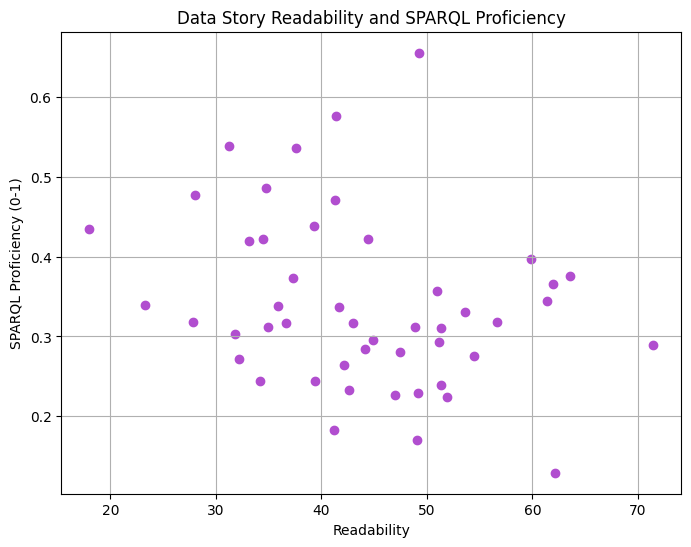

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'], color='#b14ecf')
# plt.scatter(df_filtered['normalized_readability'], df_filtered['sparql_proficiency'], color='#b14ecf')
plt.xlabel("Readability")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Readability and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [5]:
from scipy.stats import pearsonr, spearmanr

# Pearson
pearson_corr, pearson_p = pearsonr(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'])
# norm_pearson_corr, norm_pearson_p = pearsonr(df_filtered['normalized_readability'], df_filtered['sparql_proficiency'])

# Spearman
spearman_corr, spearman_p = spearmanr(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'])
# norm_spearman_corr, norm_spearman_p = spearmanr(df_filtered['normalized_readability'], df_filtered['sparql_proficiency'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: -0.273 (p-value: 0.061)
Spearman correlation: -0.290 (p-value: 0.046)


Spearman: statistically significant (p < 0.05) negative monotonic relationship: As readability increases (text becomes easier), SPARQL proficiency tends to decrease — regardless of exact values.

More advanced users (higher SPARQL proficiency) might produce stories that are less readable, maybe because they use more technical vocabulary or denser text.
Since only Spearman is significant, the relationship is likely not linear, but there’s a general trend in the rankings.

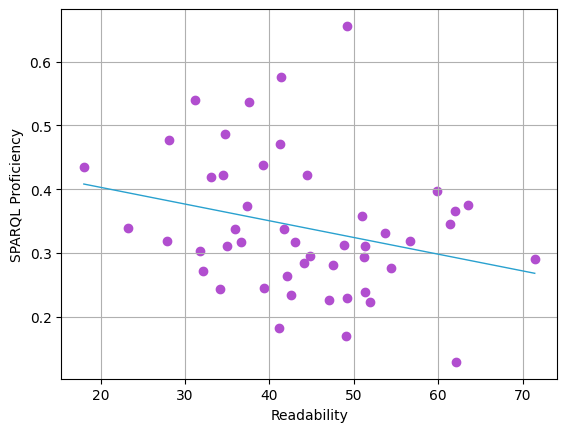

In [6]:
import numpy as np
 
x = np.array(df_filtered['flesch_reading_ease'])
# x = np.array(df_filtered['normalized_readability'])
y = np.array(df_filtered['sparql_proficiency'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color='#b14ecf', label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color='#29a1cf', linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Readability")
plt.ylabel("SPARQL Proficiency")
plt.grid(True)
plt.show()

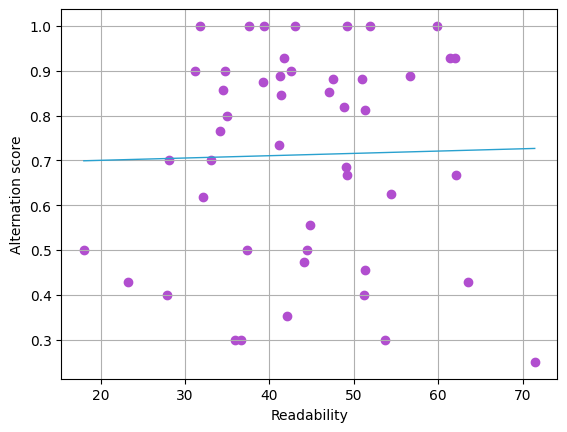

In [7]:
x = np.array(df_filtered['flesch_reading_ease'])
# x = np.array(df_filtered['normalized_readability'])
y = np.array(df_filtered['alternation_score'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color='#b14ecf', label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color='#29a1cf', linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Readability")
plt.ylabel("Alternation score")
plt.grid(True)
plt.show()

In [8]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation (measures linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation (measures monotonic relationship, rank-based)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# forse non adeguate perché in questo caso la relazione è non lineare e non è monotonica?

Pearson correlation: 0.025 (p-value: 0.867)
Spearman correlation: 0.040 (p-value: 0.787)


C:\Users\giuli\AppData\Local\Temp\ipykernel_10716\299553589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)


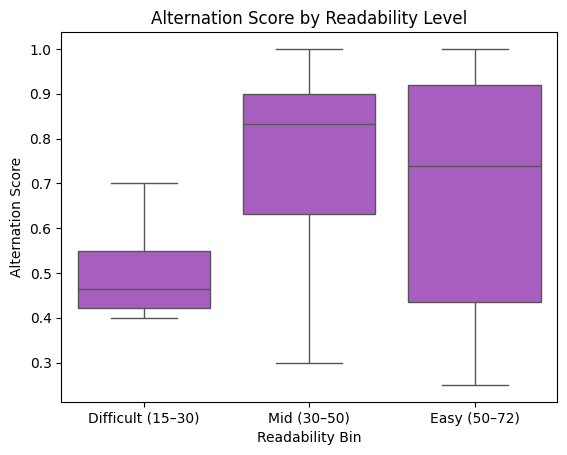

In [11]:
# We suspect that a midle range of readability is best, so we define a Middle Band
import seaborn as sns
bins = [15, 30, 50, 72]  # Low, mid, high within your actual data
labels = ['Difficult (15–30)', 'Mid (30–50)', 'Easy (50–72)']
df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)

sns.boxplot(x='readability_bin', y='alternation_score', data=df_filtered, color='#b14ecf')
plt.xlabel('Readability Bin')
plt.ylabel('Alternation Score')
plt.title('Alternation Score by Readability Level')
plt.show()



C:\Users\giuli\AppData\Local\Temp\ipykernel_10716\914008218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)


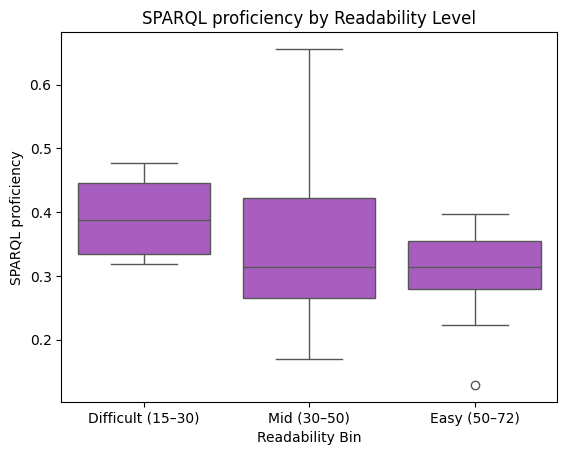

In [12]:
import seaborn as sns
bins = [15, 30, 50, 72]  # Low, mid, high within your actual data
labels = ['Difficult (15–30)', 'Mid (30–50)', 'Easy (50–72)']
df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)
y = np.array(df_filtered['sparql_proficiency'])

sns.boxplot(x='readability_bin', y='sparql_proficiency', data=df_filtered, color='#b14ecf')
plt.xlabel('Readability Bin')
plt.ylabel('SPARQL proficiency')
plt.title('SPARQL proficiency by Readability Level')
plt.show()

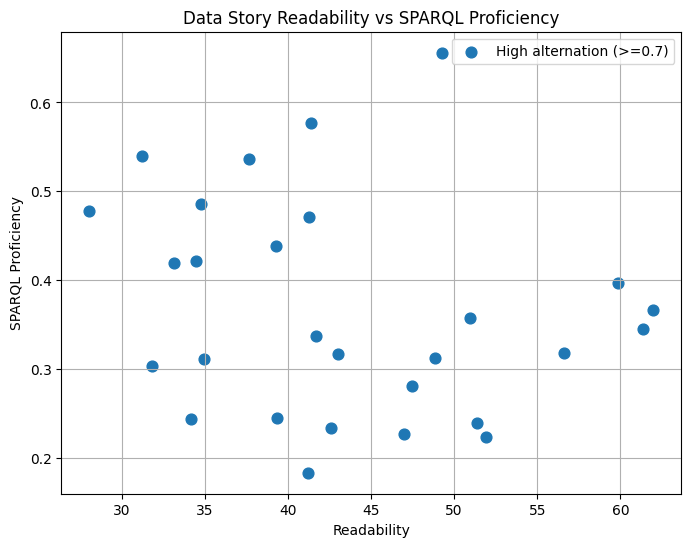

In [13]:
# Create a boolean mask: True if alternation_score > 0.7, else False
high_alternation = df_filtered['alternation_score'] >= 0.7

plt.figure(figsize=(8, 6))

# Plot points with high alternation score
plt.scatter(
    df_filtered.loc[high_alternation, 'flesch_reading_ease'],  # x-values
    df_filtered.loc[high_alternation, 'sparql_proficiency'],      # y-values
    label='High alternation (>=0.7)', 
    marker='o',  # shape of points
    s=60  # size of points
)

plt.xlabel('Readability')
plt.ylabel('SPARQL Proficiency')
plt.title('Data Story Readability vs SPARQL Proficiency')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from scipy.stats import pearsonr, spearmanr

df_high = df_filtered[high_alternation]

# Extract the columns of interest
x = df_high['flesch_reading_ease']
y = df_high['sparql_proficiency']

# Pearson correlation (measures linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation (measures monotonic relationship, rank-based)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: -0.215 (p-value: 0.271)
Spearman correlation: -0.242 (p-value: 0.215)


Among stories with high alternation score (≥ 0.7):
- There's no strong or statistically significant relationship between how readable the story is and how proficient the author is with SPARQL.
- It may suggest that high alternation stories are more diverse in structure and style, regardless of user proficiency.

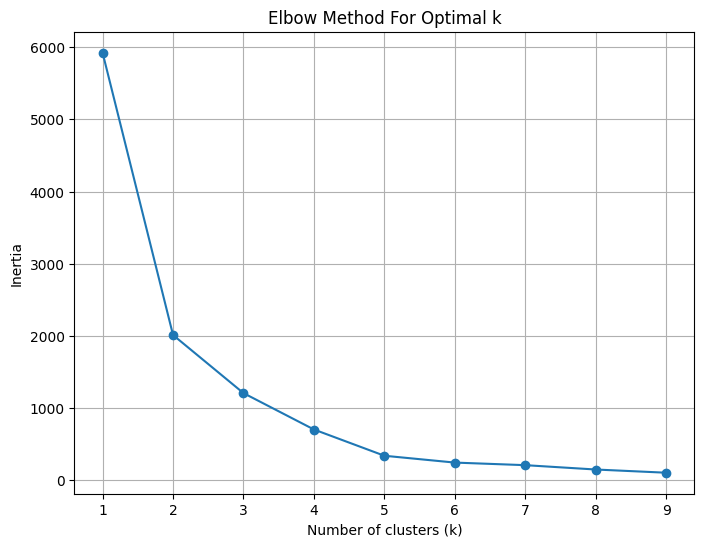

In [15]:
# Import KMeans for clustering
from sklearn.cluster import KMeans

X = df_filtered[['flesch_reading_ease', 'sparql_proficiency']].values

# List to store inertia values for each k
inertia = []

# Range of number of clusters to try (very common default, also small dataset)
k_range = range(1, 10)

# Loop over different values of k to find the inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to the closest centroid

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


C:\Users\giuli\AppData\Local\Temp\ipykernel_10716\3983547080.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.fit_predict(X)


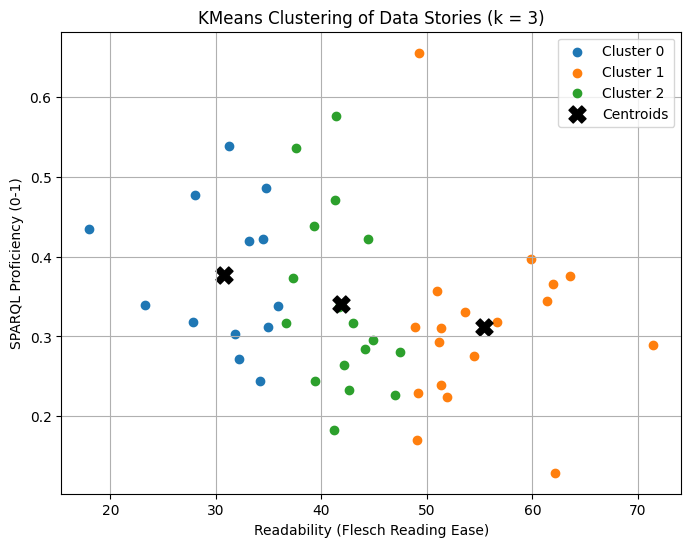

In [19]:
from sklearn.cluster import KMeans

X = df_filtered[['flesch_reading_ease', 'sparql_proficiency']].values

# Set the optimal number of clusters (based on the elbow method)
k_optimal = 3 

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))

for cluster_id in range(k_optimal):
    cluster_points = df_filtered[df_filtered['cluster'] == cluster_id]
    plt.scatter(cluster_points['flesch_reading_ease'], 
                cluster_points['sparql_proficiency'], 
                label=f'Cluster {cluster_id}')

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            s=150, marker='X', c='black', label='Centroids')

plt.xlabel("Readability (Flesch Reading Ease)")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title(f"KMeans Clustering of Data Stories (k = {k_optimal})")
plt.legend()
plt.grid(True)
plt.show()
